## Comparison case with MLP

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Neural Network Definition
class ANN(nn.Module):
    def __init__(self, input_features):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_features, 24)
        self.layer2 = nn.Linear(24, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Function to train the model with early stopping
def train_ann(model, train_loader, val_loader, epochs=200, patience=10):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)

        if epoch % 10 == 0:  # Print every 10 steps
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Function to evaluate the ANN model
def evaluate_ann(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return predictions, actuals

# Function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = (predictions * y_std) + y_mean
    actuals_denorm = (actuals * y_std) + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

def generate_hourly_series(start_month, start_day, end_month, end_day):
    y0 = 2001  # 非闰年
    y1 = y0 if start_month <= end_month else y0 + 1
    
    full_year = pd.date_range(start=f'{y0}-01-01', end=f'{y1}-12-31 23:00:00', freq='h')

    start_date = f'{y0}-{start_month:02d}-{start_day:02d}'
    end_date = f'{y1}-{end_month:02d}-{end_day:02d} 23:59:59'
    filtered_series = full_year[(full_year >= start_date) & (full_year <= end_date)]
    
    hours_in_year = (filtered_series - pd.Timestamp(f'{y0}-01-01')).total_seconds() // 3600
    hours_in_year = hours_in_year % 8760  # Normalize for non-leap year

    return hours_in_year

In [38]:
# Load data
dataset = pd.read_excel('K1-自保温-杭州.xlsx')
hours = generate_hourly_series(7, 15, 8, 15)

data = dataset.iloc[hours].copy() 
data.reset_index(drop=True, inplace=True)

# Parameters for lag
N = 24  # Number of lags for temperature
M = 1   # Prediction step for heat flow

# Generate lagged features for temperatures
for lag in range(1, N):
    data[f'Outdoor_temp_lag_{lag}'] = data['Outdoor_temp'].shift(lag)
    data[f'Indoor_temp_lag_{lag}'] = data['Indoor_temp'].shift(lag)

# Generate lagged features for heat flow
for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)

# Define input and output features
input_features = ['Outdoor_temp', 'Indoor_temp'] + [f'Outdoor_temp_lag_{i}' for i in range(1, N)] + [f'Indoor_temp_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)]

# Extract input and output data
x_data = data[input_features].values
y_data = data[output_features].values

# Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data, axis=0)
y_std = np.std(y_data, axis=0)

# Check for zero standard deviation and adjust
x_std_adjusted = np.where(x_std == 0, 1e-8, x_std)

# 假设 x_data_normalized 和 y_data_normalized 是预处理后的数据
x_data_normalized = (x_data - x_mean) / x_std_adjusted
y_data_normalized = (y_data - y_mean) / y_std  # Assuming y_std is not zero

# 转换成 tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32)

# 创建 TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

# 计算训练集和测试集的大小
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# 按顺序切分数据集
train_dataset = TensorDataset(x_tensor[:train_size], y_tensor[:train_size])
test_dataset = TensorDataset(x_tensor[train_size:], y_tensor[train_size:])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)


# Initialize the model, optimizer, and loss function
model = ANN(input_features=len(input_features))

# Train the model
train_ann(model, train_loader, test_loader, epochs=2000, patience=10)

# Evaluate the model
predictions, actuals = evaluate_ann(model, test_loader)

# Calculate and display performance metrics
mae, mse, r2 = calculate_metrics(predictions.flatten(), actuals.flatten(), y_std, y_mean)
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}")

predictions, actuals = evaluate_ann(model, test_loader)  # This should give predictions with the correct shape now
predictions_denorm = (predictions * y_std) + y_mean  # Ensure broadcasting works correctly

y_actual_denorm = (y_tensor.numpy() * y_std) + y_mean
start_index = int(0.8 * len(y_actual_denorm))
y_actual_last_20pct = y_actual_denorm[start_index:]

## 输出预测结果
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

Epoch [1/2000], Loss: 0.1845, Val Loss: 0.2693
Epoch [11/2000], Loss: 0.0354, Val Loss: 0.0147
Epoch [21/2000], Loss: 0.0422, Val Loss: 0.0132
Epoch [31/2000], Loss: 0.0413, Val Loss: 0.0134
Early stopping triggered
MAE: 0.35534047373374017, MSE: 0.18330519730708678, R2: 0.9846861835522593
MAE: 0.3753266348978886, MSE: 0.21477892962143103, R2: 0.9847219563032552


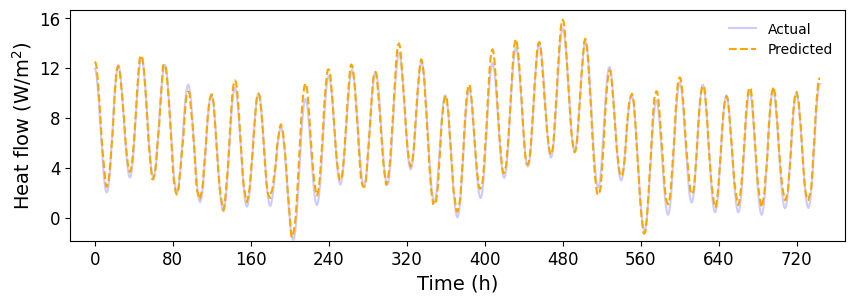

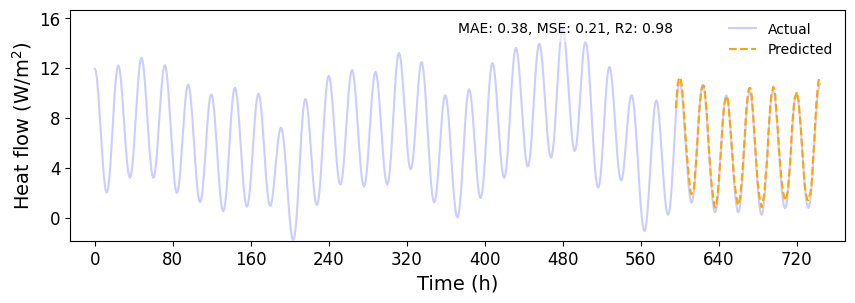

MAE: 2.008317470550537, MSE: 6.080259799957275, R2: 0.8161628842353821


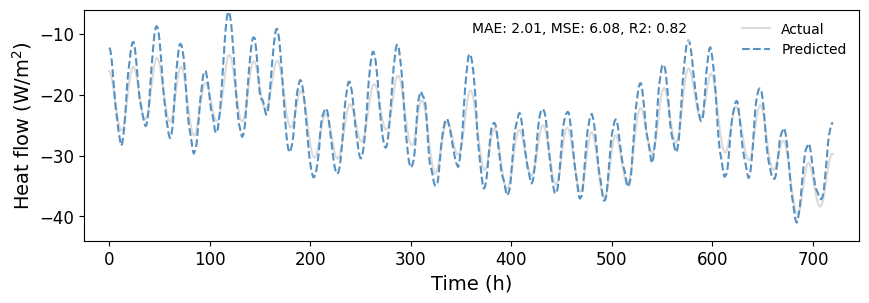

In [39]:
total_points = len(predicted)
index_20_percent = int(total_points * 0.8)  # 计算开始显示数据的索引
x_axis_indices = np.arange(index_20_percent, total_points)  # 计算后20%数据的x轴索引

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(range(total_points), predicted * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X轴范围从0到数据点总数
y_min = min(min(predicted * y_std + y_mean), min(y_data))  # 计算y轴的最小值
y_max = max(max(predicted * y_std + y_mean), max(y_data))  # 计算y轴的最大值

adjusted_y_min = y_min * 1.05 if y_min < 0 else y_min * 0.95
adjusted_y_max = y_max * 1.05 if y_max > 0 else y_max * 0.95
plt.ylim(adjusted_y_min, adjusted_y_max)  # 设置Y轴的范围
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # 设置刻度个数
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # 设置主刻度标签的大小
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
# 保存并显示图形
plt.savefig('ComparisonPlot_PredictedLast20Percent.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(x_axis_indices, predicted[index_20_percent:] * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X轴范围从0到数据点总数
y_min = min(min(predicted * y_std + y_mean), min(y_data))  # 计算y轴的最小值
y_max = max(max(predicted * y_std + y_mean), max(y_data))  # 计算y轴的最大值

adjusted_y_min = y_min * 1.05 if y_min < 0 else y_min * 0.95
adjusted_y_max = y_max * 1.05 if y_max > 0 else y_max * 0.95
plt.ylim(adjusted_y_min, adjusted_y_max)  # 设置Y轴的范围
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # 设置刻度个数
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # 设置主刻度标签的大小
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))
plt.savefig('MLP2layer-tranningResult', dpi=300, bbox_inches='tight')
plt.show()

# 数据导入
dataset = pd.read_excel('K1-自保温-哈尔滨.xlsx')
hours = generate_hourly_series(11, 15, 12, 15)

data = dataset.iloc[hours].copy()
data.reset_index(drop=True, inplace=True)

for lag in range(1, N):  # 生成时滞数据
    data[f'Outdoor_temp_lag_{lag}'] = data['Outdoor_temp'].shift(lag)
    data[f'Indoor_temp_lag_{lag}'] = data['Indoor_temp'].shift(lag)

for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)

data.dropna(inplace=True)  # 删除因为时滞而产生的NaN行

input_features = ['Outdoor_temp', 'Indoor_temp'] + [f'Outdoor_temp_lag_{i}' for i in range(1, N)] + [f'Indoor_temp_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)]  # 选择输入和输出列

x_data = data[input_features].values  # 输入数据
y_data = data[output_features].values  # 输出数据

# 标准化数据
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std
y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# 转化为tensor 结构
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)

# 模拟一些输出预测结果
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

total_points = len(predicted)

# 创建图形
plt.figure(figsize=(10, 3))

# 绘制数据
plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='#4c4c4c', alpha=0.2)
plt.plot(range(total_points), predicted * y_std + y_mean, label='Predicted', linestyle='--', color='#5591c2')

# 设置坐标轴标签和刻度范围
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points + 25)
plt.ylim(-44, -6)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))
plt.savefig('MLP-2layer-extrapolation', dpi=300, bbox_inches='tight')
plt.show()
